In [1]:
import pyzed.sl as sl
import numpy as np
import pandas as pd

In [2]:
svo_path = '../data/Schlieren/svo/HD1080_SN35520970_11-03-24.svo'

In [3]:
# Define the known points in both the global and court's coordinate systems
calibration_points = np.array([
    [0.404, -1.434, -13.462], # service line center
    [3.263, -1.300, -11.118], # service x singles sideline
    [0.446, -1.444, -7.882] # baseline x singles sideline
])

In [4]:
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

SUCCESS

In [5]:
# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 20
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]

In [6]:
detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()

detected_objects_list = []

while zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    # Retrieve objects
    zed.retrieve_objects(detected_objects, detection_parameters_rt)

    frame_nr = zed.get_svo_position()

    for i, obj in enumerate(detected_objects.object_list):
        if obj.tracking_state == sl.OBJECT_TRACKING_STATE.OK:
            detected_objects_list.append({
                'obj': obj,
                'obj_nr': i,
                'frame_nr': frame_nr
            })

KeyboardInterrupt: 

In [ ]:
df_detected_objects = pd.DataFrame(
    data=[
        [
            obj['frame_nr'],
            obj['obj_nr'],
            obj['obj'].id,
            obj['obj'].label,
            obj['obj'].confidence,
            obj['obj'].tracking_state,
            obj['obj'].position[0],
            obj['obj'].position[1],
            obj['obj'].position[2],
            obj['obj'].velocity[0],
            obj['obj'].velocity[1],
            obj['obj'].velocity[2],
            obj['obj'].dimensions[0],
            obj['obj'].dimensions[1],
            obj['obj'].dimensions[2]
        ] for obj in detected_objects_list
    ],
    columns=['frame', 'object', 'object_id', 'object_label', 'confidence', 'tracking_state', 'x', 'y', 'z', 'vx', 'xy', 'vz', 'width', 'height', 'length']
)

In [ ]:
df_detected_objects.to_csv('df_detected_objects.csv', index=False, float_format='%.5f')

In [46]:
df_detected_objects = pd.read_csv('df_detected_objects.csv')

In [47]:
def get_translation_funcs(global_points):
    court_points = np.array([
        [0, 0, 6.4],
        [4.11, 0, 6.4],
        [4.11, 0, 11.88]
    ])

    # Calculate the centroids of the points
    centroid_global = np.mean(global_points, axis=0)
    centroid_court = np.mean(court_points, axis=0)

    # Center the points by subtracting the centroids
    centered_global = global_points - centroid_global
    centered_court = court_points - centroid_court

    # Calculate the covariance matrix
    covariance_matrix = np.dot(centered_global.T, centered_court)

    # Perform singular value decomposition
    U, S, Vt = np.linalg.svd(covariance_matrix)

    # Calculate the rotation matrix
    rotation_matrix = np.dot(U, Vt)

    # If the determinant of the rotation matrix is -1, adjust for proper orientation
    if np.linalg.det(rotation_matrix) < 0:
        Vt[2, :] *= -1
        rotation_matrix = np.dot(U, Vt)

    # Calculate the translation vector
    translation_vector = centroid_court + np.dot(rotation_matrix, centroid_global)

    print(translation_vector)

    return lambda x: np.dot(rotation_matrix, x) + translation_vector, lambda x: np.dot(rotation_matrix, x)

translation_func, rotation_func = get_translation_funcs(calibration_points)

[10.59703377 -0.99569596  0.59898035]


In [48]:
df_transformed_objects = df_detected_objects.copy()
transformed_xyz = df_transformed_objects[['x', 'y', 'z']].apply(lambda x: translation_func(x), axis=1)
df_transformed_objects['x'] = transformed_xyz.apply(lambda x: x[0] - 1.5)
df_transformed_objects['y'] = transformed_xyz.apply(lambda x: x[1])
df_transformed_objects['z'] = transformed_xyz.apply(lambda x: x[2] - 6.4)

C:\Program Files\Python311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='frame', ylabel='object_id'>

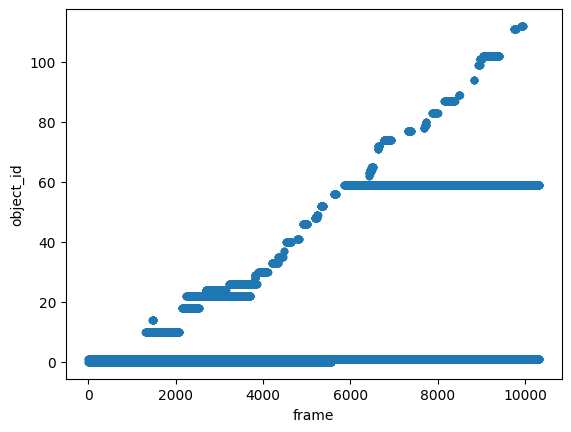

In [49]:
df_transformed_objects.plot.scatter(x='frame', y='object_id', colormap='viridis')

In [50]:
df_transformed_objects['object_id'].value_counts().head(10)

object_id
1      10214
0       5552
59      4444
22      1329
10       740
26       515
102      375
18       311
24       265
87       196
Name: count, dtype: int64

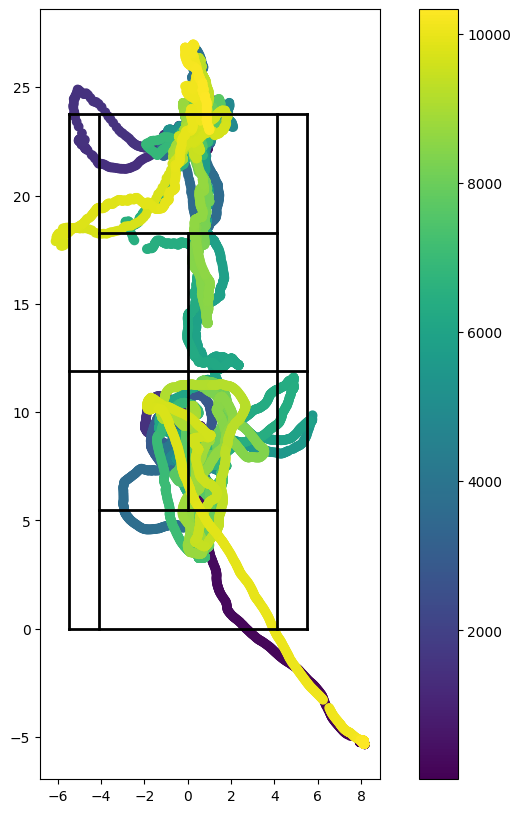

In [52]:
import matplotlib.pyplot as plt
df_filtered = df_transformed_objects[df_transformed_objects['object_id'].isin([0,1,59])]

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(x=df_filtered['x'], y=df_filtered['z'], c=df_filtered['frame'], cmap='viridis')
plt.plot([4.11, 4.11], [0, 23.77], 'k', lw=2)
plt.plot([5.48, 5.48], [0, 23.77], 'k', lw=2)
plt.plot([-4.11, -4.11], [0, 23.77], 'k', lw=2)
plt.plot([-5.48, -5.48], [0, 23.77], 'k', lw=2)
plt.plot([0, 0], [5.48, 18.28], 'k', lw=2)
plt.plot([-5.48, 5.48], [11.88, 11.88], 'k', lw=2)
plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2)
plt.plot([-5.48, 5.48], [23.77, 23.77], 'k', lw=2)
plt.plot([-4.11, 4.11], [5.48, 5.48], 'k', lw=2)
plt.plot([-4.11, 4.11], [18.28, 18.28], 'k', lw=2)

plt.colorbar()

ax.set_aspect('equal')

plt.show()

<Axes: xlabel='x', ylabel='z'>

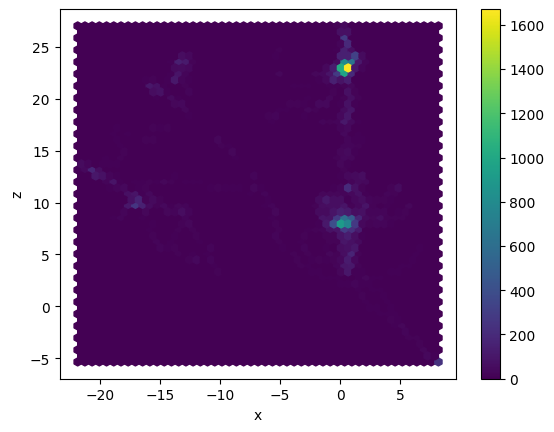

In [53]:
df_transformed_objects.plot.hexbin(x='x', y='z', cmap='viridis', gridsize=50)

In [54]:
zed.disable_object_detection()
zed.disable_positional_tracking()
zed.close()

In [1]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.41, 6.39], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben


C:\FHNW_Programmiersachen\3_Sem\fhnw-cda2-tennis-analysis\helperClasses\DataPipeline.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum_of_pair = value_counts.iloc[i][1] + value_counts.iloc[j][1]
C:\FHNW_Programmiersachen\3_Sem\fhnw-cda2-tennis-analysis\helperClasses\DataPipeline.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pairs.append((value_counts.iloc[i][0], value_counts.iloc[j][0], sum_of_pair))


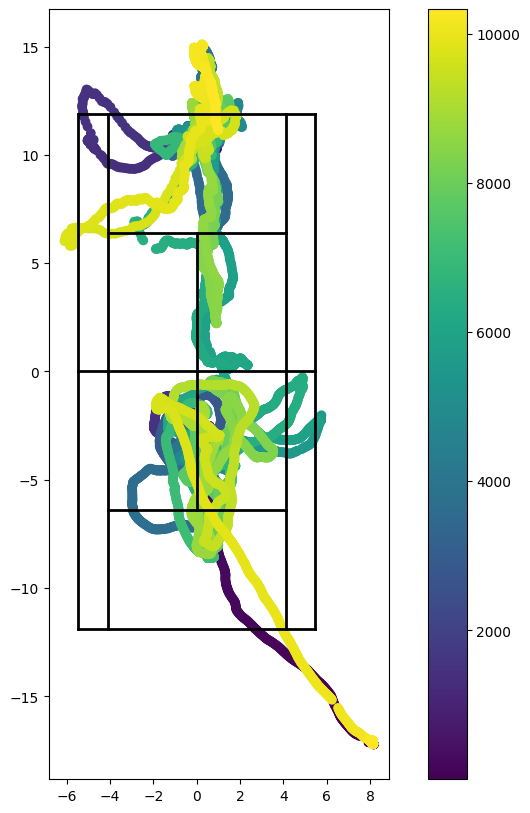

In [2]:
from helperClasses.BaseTransformation import BaseTransformation
from helperClasses.DataPipeline import DataPipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('df_detected_objects.csv')


calibration_points = np.array([
    [0.404, -1.434, -13.462], # service line center
    [3.263, -1.300, -11.118], # service x singles sideline
    [0.446, -1.444, -7.882] # baseline x singles sideline
])
bt = BaseTransformation(calibration_points)
data = bt.transformData(data, [-1.5, 0, -18.28])

dp = DataPipeline()
data = dp.mergePersons(data, 0.7, 0.1)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=data['x'], y=data['z'], c=data['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

**Statistik obere Feldhälfte**

In [3]:
dataPlayerOne = data[data['object_id'] == 1]

C:\Users\denis\AppData\Local\Temp\ipykernel_14004\1124603841.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPlayerOne.loc[dataPlayerOne['frame'] == frame, 'Position'] = 'defensiv'


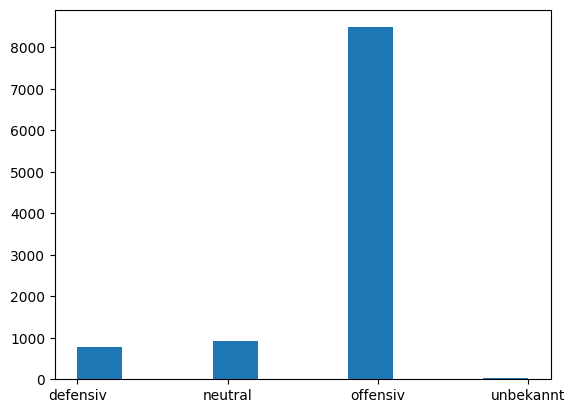

In [4]:
for index, row in dataPlayerOne.iterrows():
    z_value = row['z']
    frame = row['frame']
    if 0 < z_value < 11.88:
        dataPlayerOne.loc[dataPlayerOne['frame'] == frame, 'Position'] = 'offensiv'
    elif 11.88 < z_value < 12.88:
        dataPlayerOne.loc[dataPlayerOne['frame'] == frame, 'Position'] = 'neutral'
    elif z_value > 12.88:
        dataPlayerOne.loc[dataPlayerOne['frame'] == frame, 'Position'] = 'defensiv'
    else:
        dataPlayerOne.loc[dataPlayerOne['frame'] == frame, 'Position'] = 'unbekannt'

plt.hist(dataPlayerOne['Position'])
plt.show()